cuda


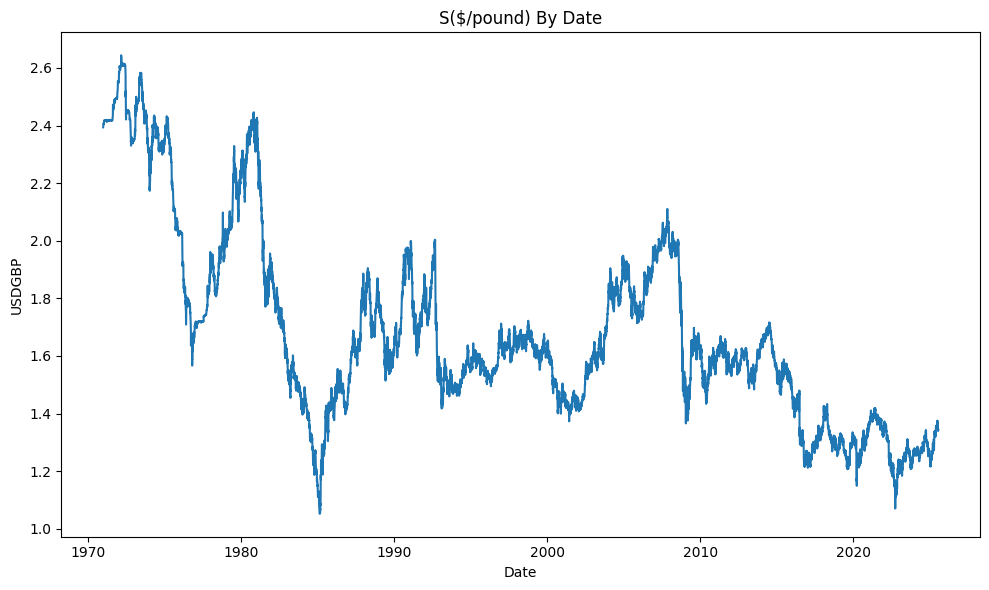

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.pytorch


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()


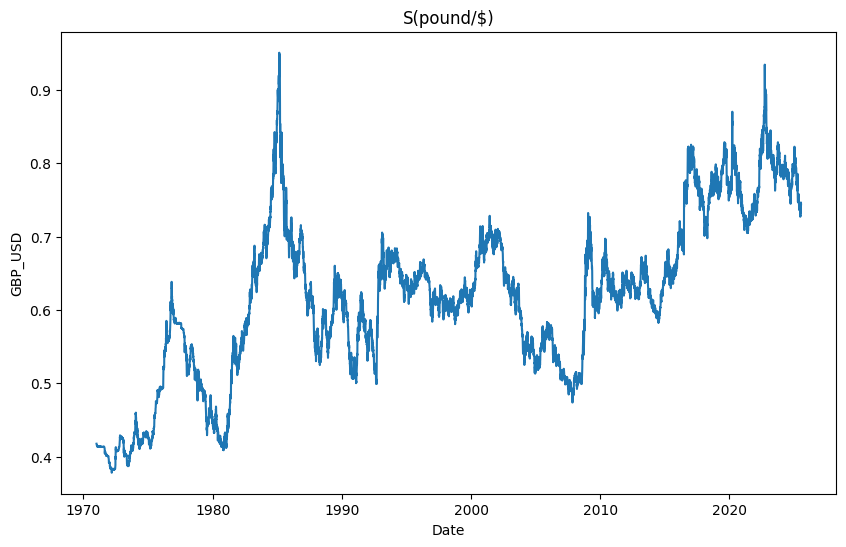

In [2]:
df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()

In [3]:
GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')

1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3426     0.74482348]
  [0.74482348 1.3426    ]]

 [[1.3413     0.74554537]
  [0.74554537 1.3413    ]]

 [[1.3439     0.74410298]
  [0.74410298 1.3439    ]]]


In [4]:
df1 = df.copy()


df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 4

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()






class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out


input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

gru_model = GRU(input_size,hidden_size,num_layers,output_size)
epochs = 500
learning_rate = 0.001
optimizer_gru = torch.optim.Adam(params=gru_model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


In [5]:
with mlflow.start_run() as run:

    mlflow.log_params({
        "input_size": input_size,
        "hidden_size": hidden_size,
        "num_layers": num_layers,
        "output_size": output_size,
        "epochs": epochs,
        "learning_rate": learning_rate,
        "optimizer": optimizer_gru.__class__.__name__,
        "loss_function": loss_fn.__class__.__name__
    }) 

    for epoch in range(epochs):
        y_pred = gru_model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        optimizer_gru.zero_grad()
        loss.backward()
        optimizer_gru.step()

        if epoch % 1 != 0:
            continue

        gru_model.eval()
        with torch.no_grad():
            y_pred_train = gru_model(X_train)
            train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
            y_pred_test = gru_model(X_test)
            test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))
            print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

         
            mlflow.log_metric("train_rsme", train_rsme, step=epoch) 
            mlflow.log_metric("test_rsme", test_rsme, step=epoch) 


    mlflow.pytorch.log_model(pytorch_model=gru_model, artifact_path="gru_model")

C:\Users\katsa\AppData\Local\Temp\ipykernel_20740\237286656.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred_train, y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_20740\237286656.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test, y_test))


Epoch: 0; train_RSEM: 0.4515; Test RSME: 0.1374
Epoch: 1; train_RSEM: 0.4057; Test RSME: 0.09535
Epoch: 2; train_RSEM: 0.3592; Test RSME: 0.05605
Epoch: 3; train_RSEM: 0.312; Test RSME: 0.03873
Epoch: 4; train_RSEM: 0.2647; Test RSME: 0.07007
Epoch: 5; train_RSEM: 0.2197; Test RSME: 0.12
Epoch: 6; train_RSEM: 0.1829; Test RSME: 0.1767
Epoch: 7; train_RSEM: 0.1656; Test RSME: 0.2367
Epoch: 8; train_RSEM: 0.1757; Test RSME: 0.2951
Epoch: 9; train_RSEM: 0.2011; Test RSME: 0.3414
Epoch: 10; train_RSEM: 0.2198; Test RSME: 0.3661
Epoch: 11; train_RSEM: 0.2228; Test RSME: 0.3686
Epoch: 12; train_RSEM: 0.2123; Test RSME: 0.3544
Epoch: 13; train_RSEM: 0.1945; Test RSME: 0.3294
Epoch: 14; train_RSEM: 0.1754; Test RSME: 0.2991
Epoch: 15; train_RSEM: 0.1601; Test RSME: 0.2674
Epoch: 16; train_RSEM: 0.1513; Test RSME: 0.237
Epoch: 17; train_RSEM: 0.1488; Test RSME: 0.2096
Epoch: 18; train_RSEM: 0.1507; Test RSME: 0.1862
Epoch: 19; train_RSEM: 0.1545; Test RSME: 0.1673
Epoch: 20; train_RSEM: 0.1579;

2025/07/26 19:46:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch: 499; train_RSEM: 0.009433; Test RSME: 0.006912


2025/07/26 19:46:14 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/26 19:46:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/07/26 19:46:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


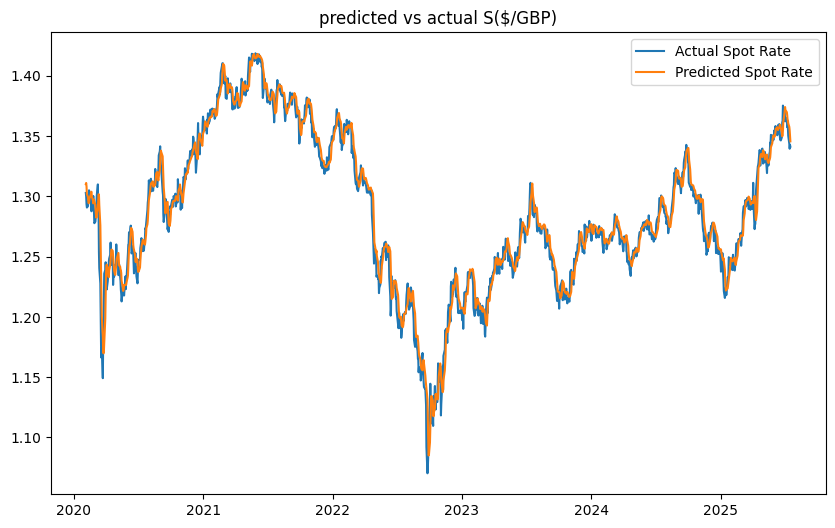

In [6]:
with torch.no_grad():
    pred = gru_model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df1.iloc[train_size + seq_length: -1]['Date']


gru_comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(gru_comparison_df['Date'],gru_comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(gru_comparison_df['Date'],gru_comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual S($/GBP)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_gru.png")
plt.show()


In [7]:
print(np.round(gru_comparison_df,4).head(20))
print(np.round(gru_comparison_df,4).tail(20))

            Date  Actual Spot Rate  Predicted Spot Rate
12314 2020-02-04            1.3029               1.3102
12315 2020-02-05            1.3000               1.3112
12316 2020-02-06            1.2935               1.3084
12317 2020-02-07            1.2908               1.3018
12318 2020-02-10            1.2919               1.2996
12319 2020-02-11            1.2945               1.2964
12320 2020-02-12            1.2978               1.2943
12321 2020-02-13            1.3051               1.2950
12322 2020-02-14            1.3039               1.2981
12323 2020-02-18            1.3017               1.3014
12324 2020-02-19            1.2934               1.3039
12325 2020-02-20            1.2877               1.3039
12326 2020-02-21            1.2966               1.2999
12327 2020-02-24            1.2923               1.2968
12328 2020-02-25            1.3004               1.2942
12329 2020-02-26            1.2921               1.2953
12330 2020-02-27            1.2876              